In [1]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
import scipy.stats
from scipy.stats import poisson
import seaborn as sns
import sklearn.neighbors
import matplotlib.pyplot as plt
%matplotlib inline

import Levenshtein

import sys
sys.path.append('..')
from lib import *

plt.style.use('../peptidome.mplstyle')

In [2]:
df_t = load_iedb_tcellepitopes()

In [3]:
k = 9
host = 'Homo sapiens'
selfset = set(count_kmers_proteome(human, k, clean=True))

In [4]:
# only specified hosts
mask = df_t['Host', 'Name'].str.match(host, na=False)
# only epitopes of length k
mask &= df_t['Epitope', 'Description'].apply(len)==k
# no host epitopes or epitopes of unknown provenance
mask &= ~df_t['Epitope', 'Parent Species'].str.contains(host, na=True)
# exclude autoimmune epitopes
mask &= ~(df_t['1st in vivo Process', 'Process Type'] == 'Occurrence of autoimmune disease')
d = df_t[mask]
d.shape[0]

29024

In [5]:
mask = d['Assay', 'Method/Technique'] == 'ELISPOT'
d = d[mask]
np.sum(mask)

19022

In [6]:
#d = d[d[('Assay', 'Method/Technique')].isin(df_t[('Assay', 'Method/Technique')].value_counts().head(10).index)]
method_pos_fraction = d[[('Assay', 'Method/Technique'),
                         ('Assay', 'Positive')]].groupby(('Assay', 'Method/Technique')).agg('mean')['Assay', 'Positive']
mask = d['Assay', 'Method/Technique'].isin(method_pos_fraction[method_pos_fraction<0.8].index)
print(np.sum(mask))
#d = d[mask]
method_pos_fraction[method_pos_fraction<0.8]

19022


(Assay, Method/Technique)
ELISPOT    0.172852
Name: (Assay, Positive), dtype: float64

In [7]:
# uniquify epitopes by keeping only the most frequent qualitative measure
def most_frequent(x):
    counts = x.value_counts(dropna=False)
    if len(counts):
        return counts.index[0]
    else:
        print(x, counts)
    return np.nan
d = d[[('Epitope', 'Description'), ('Assay', 'Positive')]].groupby(('Epitope', 'Description')).agg(most_frequent)
d = d.reset_index()
len(d)

6671

In [9]:
d0 = d['Epitope', 'Description'].apply(lambda x: x in selfset)
count0 = np.sum(d0)
d1 = d['Epitope', 'Description'].apply(lambda x: dist1(x, selfset)) & (~d0)
count1 = np.sum(d1)
d2 = d['Epitope', 'Description'].apply(lambda x: dist2(x, selfset)) & (~d0) & (~d1)
count2 = np.sum(d2)
pos0 = d[d0][d[d0]['Assay', 'Positive']].shape[0]
pos1 = d[d1][d[d1]['Assay', 'Positive']].shape[0]
pos2 = d[d2][d[d2]['Assay', 'Positive']].shape[0]
posall = d[d['Assay', 'Positive'] & (~d0) & (~d1) & (~d2)].shape[0]
ns = np.array([count0, count1, count2, d.shape[0]-count0-count1-count2])
ps = np.array([pos0, pos1, pos2, posall])/ns
ns, ps

(array([  33,  120, 2734, 3784]),
 array([0.03030303, 0.26666667, 0.2684711 , 0.21300211]))

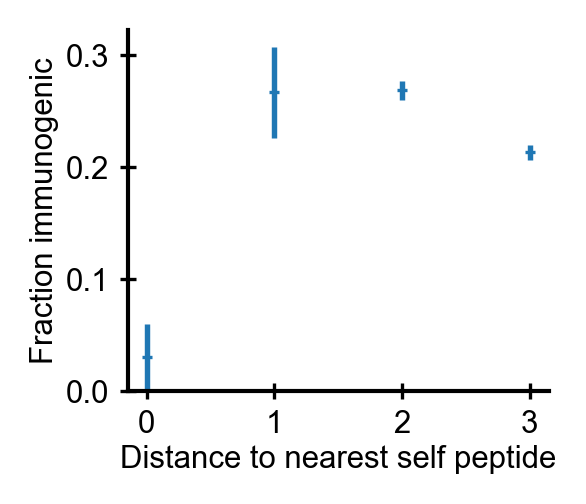

In [10]:
fig, ax = plt.subplots(figsize=(2.0, 1.75))
ax.errorbar(range(4), ps, (ps*(1-ps)/ns)**.5, ls='None', fmt='_')
#ax.set_ylim(0, 0.35)
ax.set_ylim(0.0)
ax.set_xlabel('Distance to nearest self peptide')
ax.set_ylabel('Fraction immunogenic')
fig.tight_layout()
fig.savefig(figuredir+'iedbposvsdist.svg')

In [10]:
d[d0 & d['Assay', 'Positive']]['Epitope', 'Description']

3107    LIDGISLGL
Name: (Epitope, Description), dtype: object

In [11]:
df_t[df_t['Epitope', 'Description'].isin(set(d[d0 & d['Assay', 'Positive']]['Epitope', 'Description']))
     & (df_t['Assay', 'Positive'])]['Assay']['Method/Technique'].value_counts()

ELISPOT    1
Name: Method/Technique, dtype: int64

In [12]:
d2 = df_t[df_t['Epitope', 'Description'].isin(set(d[d0]['Epitope', 'Description']))]
d2[[('Assay', 'Method/Technique'), ('Assay', 'Positive')]].groupby(('Assay', 'Method/Technique')).agg('mean')

,Assay
,Positive
"(Assay, Method/Technique)",
ELISPOT,0.01087


In [13]:
d2[d2['Assay', 'Method/Technique']=='ELISPOT'
      ][[('Epitope', 'Description'),
     ('Assay', 'Positive')]].groupby(('Epitope', 'Description')).agg(most_frequent).mean()

Assay  Positive    0.030303
dtype: float64

In [14]:
d2 = df_t[df_t['Epitope', 'Description'].isin(set(d['Epitope', 'Description']))]
d2[[('Assay', 'Method/Technique'), ('Assay', 'Positive')]].groupby(('Assay', 'Method/Technique')).agg('mean')

,Assay
,Positive
"(Assay, Method/Technique)",
3H-thymidine,0.911111
51 chromium,0.864783
BrdU,1.000000
CFSE,0.865854
ELISA,0.813406
ELISPOT,0.187000
ICS,0.775463
RNA/DNA detection,0.843750


In [15]:
d2[d2['Assay', 'Method/Technique']=='ELISPOT'
      ][[('Epitope', 'Description'),
     ('Assay', 'Positive')]].groupby(('Epitope', 'Description')).agg(most_frequent).mean()

Assay  Positive    0.236696
dtype: float64

In [16]:
from pyrepseq import *
import random

In [17]:
epitopes = d[d1]['Epitope', 'Description']

In [18]:
neighbors = []
diffposs = []
for epitope in epitopes:
    all_neighbors = set(hamming_neighbors(epitope)).intersection(selfset)
    neighbor = random.choice(list(all_neighbors))
    neighbors.append(neighbor)
    diffpos = int(np.where(np.array(list(epitope)) != np.array(list(neighbor)))[0])
    diffposs.append(diffpos)
    print(epitope, neighbor, len(all_neighbors),
          diffpos)
neighbors = np.array(neighbors)
diffposs = np.array(diffposs)

AAAPVVESK AAAKVVESK 1 3
ADTNGDPGR ADDNGDPGR 1 2
AEFTVPKFL ADFTVPKFL 1 1
AEMLREEGY AEMIREEGY 1 3
AESRKLLLI AESRKLLLR 1 8
AKLDRLDEE AKLDNLDEE 1 4
ALAHGVRVL ALRHGVRVL 1 2
ALIIIRSLL ARIIIRSLL 1 1
AMAGASTSA ASAGASTSA 1 1
APVPPPEPL APVVPPEPL 1 3
CTELKLSDN VTELKLSDN 1 0
CYNPRTNKW KYNPRTNKW 2 0
DESTLSPEM DESTLSPEE 1 8
DIDSAIETY DIDAAIETY 1 3
DLKPDNILL DLKPQNILL 10 4
DLQDRNTEL DLQDRNDEL 1 6
DRFYKVLRA DRFYKVLTA 1 7
EEAIVAYTL EEAPVAYTL 1 3
EEEEDGESL EEEEDGEEL 4 7
EEKSDINTL EEKSDIETL 1 6
EELKQKLRL EEQKQKLRL 1 2
EEQILASIL FEQILASIL 1 0
EFQVVNPHL EFQIVNPHL 1 3
ELLEQQKAA ELLEQQKRA 1 7
EYVLLLFLL EYVLLLFLA 1 8
FFPDFVITL FFPDFVWTL 1 6
FIFLLFLTL FIFLLFLPL 1 7
FLAVLSPTI FLAVLSITI 1 6
FLGERVTLT FQGERVTLT 2 1
FLLSLGIHL FLLSLGIIL 1 7
FVIFPIQYY FVIFPIQYP 1 8
FVVFILIYV FVVFLLIYV 1 4
GEPAETRVL GEPAETRVE 1 8
GLAAAVVAV GLGAAVVAV 1 2
GLADAFILL GLADAFILM 1 8
GLGTLGAAL GLGELGAAL 1 3
GLPVEYLQV GLPPEYLQV 1 3
GPGLSPGTL GPLLSPGTL 1 2
GTSNWTGNY GTSNWSGNY 1 5
GTTNSCVSV GTTNSCVAV 1 7
IEDPPFNSL IEDPPFPSL 1 6
IENIHSEMY IENVH

In [19]:
df_d1 = d[d1]
df_d1['Position difference'] = diffposs

<ipython-input-19-ad0e05671110>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_d1['Position difference'] = diffposs


<AxesSubplot:>

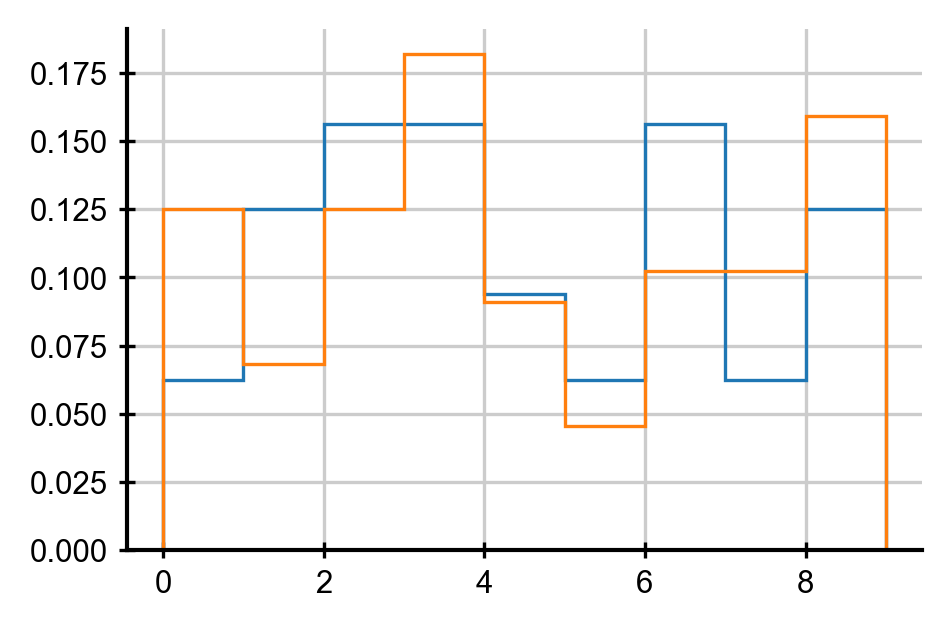

In [20]:
bins = np.arange(0,k+1,1)
df_d1[df_d1['Assay', 'Positive']]['Position difference'].hist(bins=bins, density=True, histtype='step')
df_d1[~df_d1['Assay', 'Positive']]['Position difference'].hist(bins=bins, density=True, histtype='step')

In [21]:
df_d1.groupby('Position difference').agg('count')['Epitope', 'Description']

/home/amayer/anaconda3/envs/py3/lib/python3.8/site-packages/pandas/core/generic.py:3887: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


Position difference
0    13
1    10
2    16
3    21
4    11
5     6
6    14
7    11
8    18
Name: (Epitope, Description), dtype: int64

<ErrorbarContainer object of 3 artists>

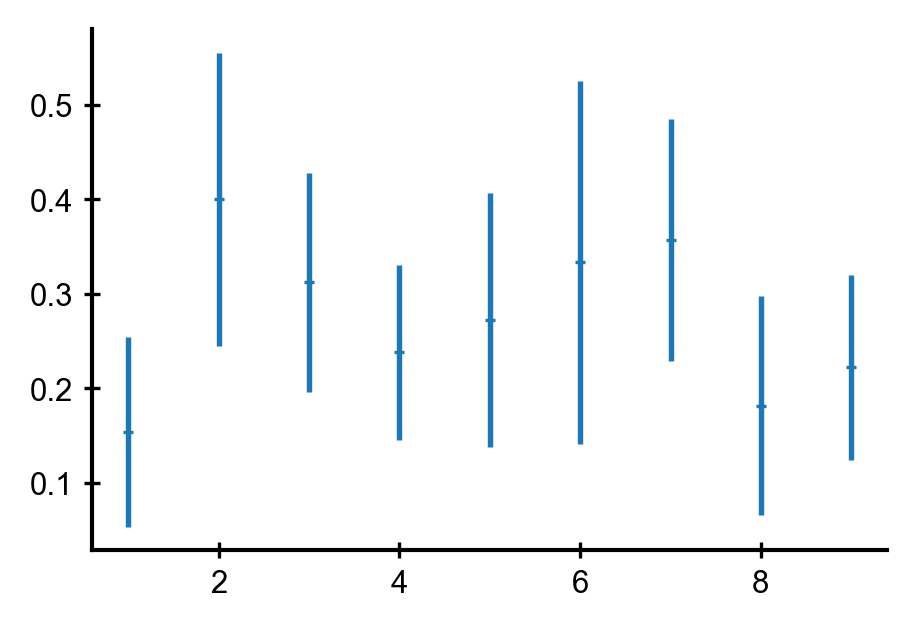

In [22]:
ps = df_d1.groupby('Position difference').agg('mean')
posdiffs = ps.index+1
ps = np.array(ps).flatten()
ns = np.array(df_d1.groupby('Position difference').agg('count')['Epitope', 'Description'])
plt.errorbar(posdiffs, ps, (ps*(1-ps)/ns)**.5, ls='None', fmt='_')